In [11]:
import tensorflow as tf
import numpy as np
from sklearn.neighbors import NearestNeighbors

In [2]:
BATCH_SIZE = 64

In [3]:
input_ph = tf.placeholder(tf.float32, (None, 6 * 20), 'input')
gt_ph = tf.placeholder(tf.float32, (None, 6))
training = tf.placeholder(tf.bool)

In [ ]:
neighbor_idx = tf.placeholder(tf.int8, (None, ))

In [4]:
out = tf.layers.dense(input_ph, 1024, activation=tf.nn.sigmoid, name='h0')
out = tf.layers.dense(out, 1024, activation=tf.nn.sigmoid, name='h1')
# out = tf.layers.dense(out, 128, activation=tf.nn.sigmoid, name='h2')
out = tf.layers.dense(out, 6, activation=None, name='output')

In [12]:
loss = tf.losses.mean_squared_error(out, gt_ph)
rho_o, c, r = 0, 0, 0
diff = out - tf.concat([out[:,:3]]*20, 1)
diff = tf.reshape(diff, [None, 20, 3])
imcomp = tf.reduce_mean((c/rho_o*tf.reduce_sum(tf.nn.relu(r**2 - tf.norm(diff, axis=2))**3, axis=1) - 1)**2)
loss += imcomp

ValueError: Dimensions must be equal, but are 6 and 60 for 'sub_1' (op: 'Sub') with input shapes: [?,6], [?,60].

In [8]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-5)
#, momentum=0.9 , use_nesterov=True

In [9]:
opt = optimizer.minimize(loss)

# data loading

In [20]:
# load data
_data = np.load('./input_data.npy')
_label = np.load('./output_data.npy')

In [21]:
neighbors = []
for d in _data:
    all_states = d[:,:3]
    nbrs = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(all_states)
    distances, indices = nbrs.kneighbors(all_states)
    neighborhood = []
    for idx in indices:
        neighborhood.append(all_states[[list(idx)]])
    neighbors.append(neighborhood)

In [18]:
neighbors = np.array(neighbors)
neighbors = neighbors[1:]
_data = _data[:-1]
_label = _label[:-1]

In [11]:
data = _data.reshape([-1, 120])
label = _label.reshape([-1, 6])
neighbor = neighbors.reshape([-1, 20, 3])
shuffle_idx = np.random.choice(data.shape[0], data.shape[0])
data_s = data[shuffle_idx]
label_s = label[shuffle_idx]
neighbor_s = neighbor[shuffle_idx]
data_train = data_s[:250000]
label_train = label_s[:250000]
neighbor_train = neighbor[shuffle_idx]
data_val = data_s[250000:]
label_val = label_s[250000:]
neighbor_val = neighbor[shuffle_idx]

# training

In [12]:
sess = tf.InteractiveSession()

In [13]:
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(tf.trainable_variables())

In [35]:
for i in range(1000000):
    idx = np.random.choice(data_train.shape[0], BATCH_SIZE)
    x, y = data_train[idx], label_train[idx]
    sess.run(opt, feed_dict={input_ph: x, gt_ph: y, training:True})
    if i % 5000 == 0:
        print('{}: train loss'.format(i), sess.run(loss, feed_dict={input_ph: x, gt_ph:y, training:False}))
        idx = np.random.choice(data_val.shape[0], BATCH_SIZE)
        x, y = data_val[idx], label_val[idx]
        print('{} : val loss'.format(i), sess.run(loss, feed_dict={input_ph: x, gt_ph:y, training:False}))
        saver.save(sess, './model')

0: train loss 0.0023826293
0 : val loss 0.0017635109
5000: train loss 0.00201453
5000 : val loss 0.0035770657
10000: train loss 0.0008381473
10000 : val loss 0.002443629
15000: train loss 0.0018627405
15000 : val loss 0.0025016915
20000: train loss 0.0043848916
20000 : val loss 0.0016110279
25000: train loss 0.00066035177
25000 : val loss 0.0027693005
30000: train loss 0.0048467633
30000 : val loss 0.0011977461
35000: train loss 0.0012269387
35000 : val loss 0.002981418
40000: train loss 0.0018547255
40000 : val loss 0.0022725991
45000: train loss 0.00273363
45000 : val loss 0.0010676114
50000: train loss 0.000942576
50000 : val loss 0.0010286565
55000: train loss 0.001475827
55000 : val loss 0.001727546
60000: train loss 0.002325029
60000 : val loss 0.0019876936
65000: train loss 0.0024591477
65000 : val loss 0.002076948
70000: train loss 0.0011514603
70000 : val loss 0.0022072198
75000: train loss 0.0026665423
75000 : val loss 0.0009027042
80000: train loss 0.0025286302
80000 : val l

In [46]:
diff = label[np.random.choice(data.shape[0], 64)] - label[np.random.choice(data.shape[0], 64)]

In [47]:
np.mean(np.linalg.norm(diff, axis=1))

3.141020098725048

In [25]:
data.shape

(285120, 120)

In [16]:
_data[0,0]

array([-2.98382e-01,  6.37974e-04, -2.98382e-01,  1.55282e-01,
        5.72816e-02,  1.55282e-01, -2.98881e-01,  1.39290e-04,
       -2.00300e-01,  1.08669e-01,  1.06691e-02, -2.52207e-02,
       -2.00300e-01,  1.39290e-04, -2.98881e-01, -2.52227e-02,
        1.06695e-02,  1.08670e-01, -2.98881e-01,  9.87198e-02,
       -2.98881e-01,  1.08668e-01, -1.23220e-01,  1.08670e-01,
       -2.00287e-01, -3.81268e-04, -2.00287e-01, -2.49715e-02,
       -3.78658e-02, -2.49699e-02, -2.00287e-01,  9.87330e-02,
       -2.99401e-01, -2.49707e-02, -1.22969e-01,  6.01347e-02,
       -2.99401e-01,  9.87330e-02, -2.00287e-01,  6.01329e-02,
       -1.22971e-01, -2.49708e-02, -2.00277e-01,  9.87426e-02,
       -2.00277e-01, -2.51209e-02, -1.23122e-01, -2.51207e-02,
       -2.98873e-01,  1.99035e-01, -2.98873e-01,  1.08348e-01,
       -9.70734e-02,  1.08348e-01, -9.99831e-02,  1.46698e-04,
       -2.98873e-01,  1.06019e-03,  1.03510e-02,  1.08351e-01,
       -2.98873e-01,  1.46698e-04, -9.99831e-02,  1.083

In [10]:
diff = data[:, :6] - label

In [11]:
np.mean(np.linalg.norm(diff, axis=1))

0.10635913333156506

In [ ]:
out = tf.layers.dense(input_ph, 512, activation=tf.nn.relu, name='h0')
# out = tf.layers.dropout(out, rate=0.2, training=training)
out = tf.layers.dense(out, 512, activation=tf.nn.relu, name='h1')
# out = tf.layers.dropout(out, rate=0.2, training=training)
# out = tf.layers.dense(out, 64, activation=tf.nn.relu, name='h2')
# out = tf.layers.dropout(out)
out = tf.layers.dense(out, 6, activation=None, name='out')

# Simulation

In [15]:
state = _data[0]

In [17]:
nbrs = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(state[:,:3])

In [18]:
state2 = sess.run(out, feed_dict={input_ph: state})

In [19]:
state2

array([[-2.79084235e-01,  2.20874306e-02, -2.80202627e-01,
         1.43745840e-01,  3.01657543e-02,  1.30692750e-01],
       [-2.85160750e-01,  9.50539671e-03, -2.13828027e-01,
         1.00052476e-01, -1.85674801e-02, -2.87036579e-02],
       [-2.82490522e-01,  2.05842461e-02, -9.16020349e-02,
         9.52327996e-02, -1.83312073e-02, -2.02524941e-02],
       ...,
       [ 1.81120485e-01,  3.86882186e+00, -3.09583917e-03,
        -8.79900157e-02, -2.67284244e-01, -1.56037789e-02],
       [ 1.83779404e-01,  3.87545490e+00,  1.14823602e-01,
        -8.80871117e-02, -2.95959055e-01, -1.65303033e-02],
       [ 1.78188816e-01,  3.86440969e+00,  1.79825321e-01,
        -1.31647378e-01, -3.20030421e-01, -1.57218009e-01]], dtype=float32)

In [20]:
_label[0]

array([[-2.95304e-01,  1.75619e-03, -2.95304e-01,  2.92254e-01,
         9.62439e-02,  2.92254e-01],
       [-2.96774e-01,  2.86229e-04, -2.00985e-01,  2.03578e-01,
         7.56837e-03, -5.68270e-02],
       [-2.96682e-01,  3.78027e-04, -9.98663e-02,  2.09183e-01,
         1.31738e-02,  9.69506e-03],
       ...,
       [ 1.96681e-01,  3.89374e+00, -1.32428e-04, -2.09351e-01,
        -4.05340e-01, -9.32817e-03],
       [ 1.96772e-01,  3.89383e+00,  1.00982e-01, -2.04172e-01,
        -4.00161e-01,  5.57939e-02],
       [ 1.95304e-01,  3.89236e+00,  1.95304e-01, -2.92249e-01,
        -4.88237e-01, -2.92248e-01]])

In [21]:
state

array([[-2.98382e-01,  6.37974e-04, -2.98382e-01, ..., -2.52813e-02,
        -1.23282e-01,  1.96211e-04],
       [-2.98881e-01,  1.39290e-04, -2.00300e-01, ...,  5.89526e-02,
        -9.75188e-02,  6.18012e-04],
       [-2.98873e-01,  1.46698e-04, -9.99831e-02, ...,  1.08668e-01,
        -1.23220e-01,  1.08670e-01],
       ...,
       [ 1.98873e-01,  3.89789e+00, -1.68552e-05, ..., -1.08820e-01,
        -7.30709e-02, -1.08817e-01],
       [ 1.98881e-01,  3.89790e+00,  1.00300e-01, ..., -5.89647e-02,
        -9.83943e-02, -5.43839e-04],
       [ 1.98382e-01,  3.89740e+00,  1.98382e-01, ..., -1.55480e-04,
        -7.26986e-02,  2.53006e-02]])

In [22]:
np.mean(np.linalg.norm(_label[0]-state2, axis=1))

0.07162225537515556

In [42]:
def predict(state, session):
    nbrs = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(state[:,:3])
    distances, indices = nbrs.kneighbors(state[:,:3])
#     print(indices.shape)
    neighbor_idx = indices.flatten()
#     print(neighbor_idx)
#     print(neighbor_idx.shape)
    neighbors = state[[list(neighbor_idx)]]
#     print(neighbors.shape)
    neighbors = neighbors[:,:6]
#     print(neighbors.shape)
    new_state = neighbors.reshape([-1, 120])
    return session.run(out, feed_dict={input_ph: new_state})

In [26]:
predict(state, sess).shape

(1440, 6)

In [27]:
a.flatten()

NameError: name 'a' is not defined

In [28]:
a = np.array([[1,2,3,4],[5,6,7,8],[-5,-6,-7,-8],[-1,-2,-3,-4]])

In [29]:
b = a[[[0, 2, 1,3]]]

In [30]:
b

array([[ 1,  2,  3,  4],
       [-5, -6, -7, -8],
       [ 5,  6,  7,  8],
       [-1, -2, -3, -4]])

In [24]:
nbrs_pred = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(state2[:,:3])

In [25]:
distances, indices = nbrs_pred.kneighbors(state2[:,:3])

In [26]:
indices

array([[   0,  240,    6, ...,  487,  248,  253],
       [   1,    0,  241, ...,  253,   12,  486],
       [   2,    8,  242, ...,  240,  483,    4],
       ...,
       [1437, 1431, 1197, ..., 1199, 1424, 1433],
       [1438, 1439, 1198, ..., 1436,  953, 1427],
       [1439, 1199, 1433, ...,  952, 1186, 1191]], dtype=int64)

In [27]:
nbrs_gt = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(_label[0][:,:3])

In [28]:
distances, indices = nbrs_gt.kneighbors(_label[0][:,:3])

In [29]:
indices

array([[   0,  240,    1, ...,  253,  487,  248],
       [   1,    0,  241, ...,  253,  487,   14],
       [   2,  242,    8, ...,  488,  240,    6],
       ...,
       [1437, 1197, 1431, ...,  951, 1199, 1433],
       [1438, 1439, 1432, ..., 1186,  952, 1425],
       [1439, 1433, 1438, ..., 1186,  952, 1191]], dtype=int64)

In [30]:
nbrs2 = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(state)
distances, indices = nbrs2.kneighbors(state)
indices

array([[   0,    1,  240, ...,   13,  487,  480],
       [   1,    0,  241, ...,  486,   12,  482],
       [   2,    8,  242, ...,   12,  254,  240],
       ...,
       [1437, 1431, 1197, ..., 1436, 1185, 1199],
       [1438, 1433, 1199, ...,  951, 1427,  953],
       [1439, 1199, 1438, ..., 1197, 1186,  959]], dtype=int64)

In [31]:
%matplotlib inline 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

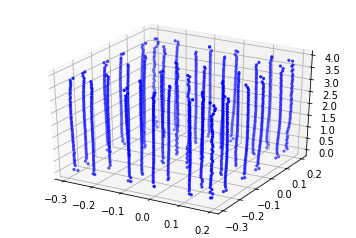

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(state2[:,0], state2[:,2], state2[:,1], c='blue', marker='.')
plt.show()

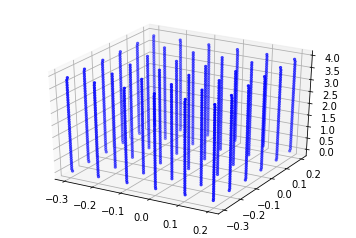

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(_label[0][:,0], _label[0][:,2], _label[0][:,1], c='blue', marker='.')
plt.show()

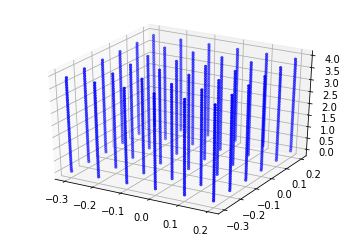

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(state[:,0], state[:,2], state[:,1], c='blue', marker='.')
plt.show()

In [65]:
def simulate(state, session, num_step=4):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(state[:,0], state[:,2], state[:,1], c='blue', marker='.')
    plt.savefig('{}.png'.format(-1))
    rtn = [state.copy()]
    for i in range(num_step):
        state = predict(state, session)
        rtn.append(state.copy())
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(state[:,0], state[:,2], state[:,1], c='blue', marker='.')
        plt.savefig('{}.png'.format(i))
        #plt.show()
    return rtn

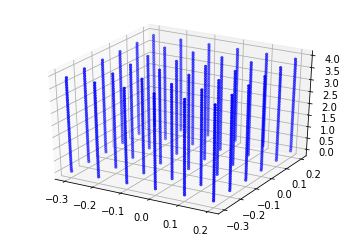

In [56]:
sequence = simulate(_data[0], sess)

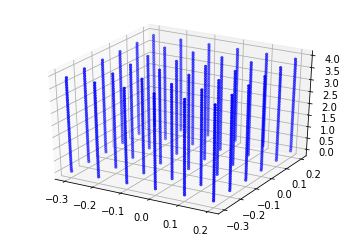

In [60]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sequence[0][:,0], sequence[0][:,2], sequence[0][:,1], c='blue', marker='.')
plt.show()

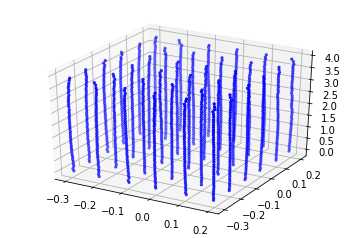

In [61]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sequence[1][:,0], sequence[1][:,2], sequence[1][:,1], c='blue', marker='.')
plt.show()

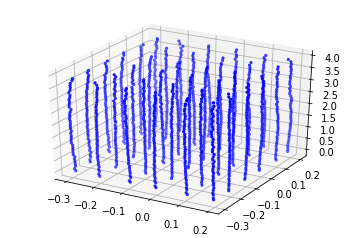

In [62]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sequence[2][:,0], sequence[2][:,2], sequence[2][:,1], c='blue', marker='.')
plt.show()

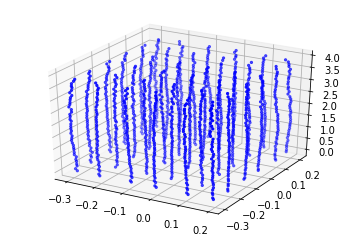

In [63]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sequence[3][:,0], sequence[3][:,2], sequence[3][:,1], c='blue', marker='.')
plt.show()

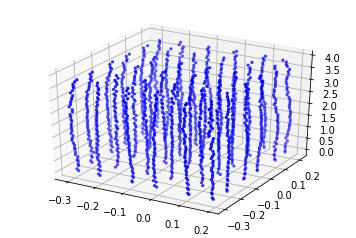

In [64]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sequence[4][:,0], sequence[4][:,2], sequence[4][:,1], c='blue', marker='.')
plt.show()

[array([[-2.98382e-01,  6.37974e-04, -2.98382e-01, ..., -2.52813e-02,
         -1.23282e-01,  1.96211e-04],
        [-2.98881e-01,  1.39290e-04, -2.00300e-01, ...,  5.89526e-02,
         -9.75188e-02,  6.18012e-04],
        [-2.98873e-01,  1.46698e-04, -9.99831e-02, ...,  1.08668e-01,
         -1.23220e-01,  1.08670e-01],
        ...,
        [ 1.98873e-01,  3.89789e+00, -1.68552e-05, ..., -1.08820e-01,
         -7.30709e-02, -1.08817e-01],
        [ 1.98881e-01,  3.89790e+00,  1.00300e-01, ..., -5.89647e-02,
         -9.83943e-02, -5.43839e-04],
        [ 1.98382e-01,  3.89740e+00,  1.98382e-01, ..., -1.55480e-04,
         -7.26986e-02,  2.53006e-02]]),
 array([[-2.9551113e-01,  7.0850495e-03, -2.9616284e-01,  1.2887897e-01,
          9.6358769e-03,  1.5514885e-01],
        [-2.9815251e-01,  2.5681646e-03, -2.0248966e-01,  9.0577349e-02,
         -3.4564186e-02, -1.2501462e-03],
        [-2.9671425e-01,  4.0673856e-03, -9.6552223e-02,  7.9756789e-02,
         -2.5296856e-02, -3.047941

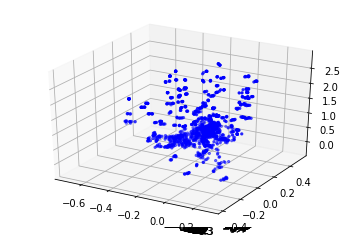

In [66]:
def predict(state, session):
    nbrs = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(state[:,:3])
    distances, indices = nbrs.kneighbors(state[:,:3])
#     print(indices.shape)
    neighbor_idx = indices.flatten()
#     print(neighbor_idx)
#     print(neighbor_idx.shape)
    neighbors = state[[list(neighbor_idx)]]
#     print(neighbors.shape)
    neighbors = neighbors[:,:6]
#     print(neighbors.shape)
    new_state = neighbors.reshape([-1, 120])
    return session.run(out, feed_dict={input_ph: new_state})

In [106]:
nbrs = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(_data[0][:,:3])
distances, indices = nbrs.kneighbors(_data[0][:,:3])
neighbor_idx = indices.flatten()

In [107]:
total_dist = distances[0]

(array([1., 0., 0., 0., 3., 3., 0., 1., 3., 9.]),
 array([0.        , 0.02420886, 0.04841772, 0.07262658, 0.09683544,
        0.1210443 , 0.14525317, 0.16946203, 0.19367089, 0.21787975,
        0.24208861]),
 <a list of 10 Patch objects>)

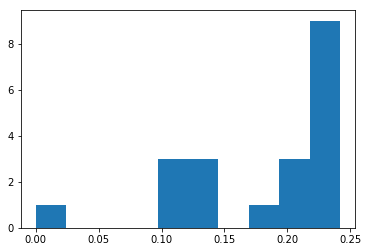

In [108]:
plt.hist(total_dist.flatten())

In [109]:
indices

array([[   0,    6,  240, ...,  253,  248,  487],
       [   1,    0,    7, ...,  253,  487,   14],
       [   2,  242,    8, ...,  488,  240,    6],
       ...,
       [1437, 1431, 1197, ..., 1185, 1433, 1199],
       [1438, 1439, 1432, ...,  952, 1186, 1425],
       [1439, 1433, 1438, ..., 1191,  952, 1186]], dtype=int64)

In [105]:
_data.shape

(198, 1440, 120)